In [1]:
train_dir = 'C:/Users/ROG/OneDrive/桌面/FYP/Dataset/Train_data/train_data_after_washing.csv'
test_dir = 'C:/Users/ROG/OneDrive/桌面/FYP/Dataset/Test_data/test_data_after_washing.csv'

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, cohen_kappa_score, roc_curve, auc, make_scorer, accuracy_score, f1_score 
tf.get_logger().setLevel('ERROR') # return ERROR messages, ignore others

In [3]:
def encode_one_hot(ori_dataframe):
    dummies = pd.get_dummies(ori_dataframe.labels)
    res = pd.concat([ori_dataframe, dummies], axis=1)
    return res

In [4]:
data = pd.read_csv(train_dir)
data = pd.DataFrame(data)
test_data = pd.read_csv(test_dir)
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
data = data[["review","rating"]]
test_data = test_data[["review","rating"]]

In [5]:
data['labels'] = data['rating'].map({1 : 0,
                                     2 : 0,
                                     3 : 0,
                                     4 : 0,
                                     5 : 1,
                                     6 : 1,
                                     7 : 1,
                                     8 : 1,
                                     9 : 2,
                                     10 : 2})

In [6]:
test_data['labels'] = test_data['rating'].map({1 : 0,
                                               2 : 0,
                                               3 : 0,
                                               4 : 0,
                                               5 : 1,
                                               6 : 1,
                                               7 : 1,
                                               8 : 1,
                                               9 : 2,
                                               10 : 2})

In [7]:
data = data[["review","labels"]]
test_data = test_data[["review","labels"]]

In [8]:
#for i in range(1,4):
#    condition = data['labels'] == i
#    subset = data[condition].sample(frac=0.3)
#    val_data = pd.concat([subset, val_data])

#train_data = data [~data.index.isin(val_data.index)]

In [9]:
#train_data = encode_one_hot(train_data)
#val_data = encode_one_hot(val_data)
#test_data = encode_one_hot(test_data)
#train_target = train_data[[1,2,3]]
#val_target = val_data[[1,2,3]]
#test_target = test_data[[1,2,3]]

In [10]:
X = data["review"].to_numpy()
y = data["labels"].to_numpy()

In [14]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu', name='classifier_dense_1')(net)
    net = tf.keras.layers.Dense(128, activation='relu', name='classifier_dense_2')(net)
    net = tf.keras.layers.Dense(128, activation='relu', name='classifier_dense_3')(net)
    net = tf.keras.layers.Dense(128, activation='relu', name='classifier_dense_4')(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier_dense_5')(net)
    return tf.keras.Model(text_input, net)

In [17]:
def ff_loss(y_true,y_pred):
    alpha = tf.constant([[1],[1],[3]], dtype=tf.float32) #adjust weight for each label
    gamma = 1.25
    epsilon = 1.e-7
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
    ce = -tf.math.log(y_t)
    weight = tf.pow(tf.subtract(1., y_t), gamma)
    fl = tf.matmul(tf.multiply(weight, ce), alpha)
    loss = tf.reduce_mean(fl)
    loss = tf.abs(loss-0.10) + 0.10
    loss = tf.convert_to_tensor(loss)
    
    return loss

In [ ]:
def model_training():
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    classifier_model = build_classifier_model()
    classifier_model.summary()
    epochs = 150
    steps_per_epoch = 0
    for _ in x_train:
        steps_per_epoch = steps_per_epoch + 1
    num_train_steps = steps_per_epoch/24 * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-6
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    classifier_model.compile(optimizer=optimizer,
                             loss=ff_loss,
                             metrics=["accuracy", tf.keras.metrics.Recall(name='recall')])
    checkpoint_path = 'C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt/cp.ckpt'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    csv_callback = tf.keras.callbacks.CSVLogger(
    'C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/record.csv', separator=',', append=False
    )
    import time
    t0 = time.time()
    print(f'Training model with {tfhub_handle_encoder}')
    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x=x_train,
                                   y=y_train,
                                   validation_data=(x_val,y_val),
                                   epochs=150,
                                   batch_size=24,
                                   callbacks=[cp_callback,csv_callback])
    t1 = time.time()
    time_train = t1-t0
    

In [11]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/albert_en_base/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/albert_en_preprocess/3'

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
classifier_model = build_classifier_model()

In [16]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [18]:
epochs = 150
steps_per_epoch = 0
for _ in x_train:
    steps_per_epoch = steps_per_epoch + 1
num_train_steps = steps_per_epoch/24 * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [19]:
classifier_model.compile(optimizer=optimizer,
                         loss=ff_loss,
                         metrics=["accuracy", tf.keras.metrics.Recall(name='recall')])

In [20]:
#classifier_model.load_weights('C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_10.51_0.25/ckpt/cp.ckpt')

In [21]:
checkpoint_path = 'C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/record.csv', separator=',', append=False
)

In [23]:
import time
t0 = time.time()
print(f'Training model with {tfhub_handle_encoder}')
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_val,y_val),
                               epochs=150,
                               batch_size=24,
                               callbacks=[cp_callback,csv_callback])
t1 = time.time()
time_train = t1-t0

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/150
917/917 [==============================] - ETA: 0s - loss: 1.7147 - accuracy: 0.3593 - recall: 0.0014
Epoch 1: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 266s 282ms/step - loss: 1.7147 - accuracy: 0.3593 - recall: 0.0014 - val_loss: 1.4121 - val_accuracy: 0.5124 - val_recall: 0.0000e+00
Epoch 2/150
917/917 [==============================] - ETA: 0s - loss: 1.3941 - accuracy: 0.5128 - recall: 0.0919
Epoch 2: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 257s 281ms/step - loss: 1.3941 - accuracy: 0.5128 - recall: 0.0919 - val_loss: 1.3427 - val_accuracy: 0.5123 - val_recall: 0.3556
Epoch 3/150
917/917 [==============================] - ETA: 0s - loss: 1.2366 - accuracy: 0.5469 - recall: 0.3140


917/917 [==============================] - 255s 279ms/step - loss: 0.2299 - accuracy: 0.9481 - recall: 0.9308 - val_loss: 1.0858 - val_accuracy: 0.7945 - val_recall: 0.7810
Epoch 23/150
917/917 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9459 - recall: 0.9296
Epoch 23: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 256s 279ms/step - loss: 0.2381 - accuracy: 0.9459 - recall: 0.9296 - val_loss: 1.0589 - val_accuracy: 0.7931 - val_recall: 0.7777
Epoch 24/150
917/917 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9486 - recall: 0.9328
Epoch 24: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 278ms/step - loss: 0.2246 - accuracy: 0.9486 - recall: 0.9328 - val_loss: 1.0392 - val_accuracy: 0.7924 - val_recall: 0.7780
Epoch 25/150
917/917 [==============================] - ETA: 0s - loss: 0

Epoch 66/150
917/917 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9725 - recall: 0.9701
Epoch 66: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 256s 279ms/step - loss: 0.1888 - accuracy: 0.9725 - recall: 0.9701 - val_loss: 1.1442 - val_accuracy: 0.7853 - val_recall: 0.7784
Epoch 67/150
917/917 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9747 - recall: 0.9722
Epoch 67: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 279ms/step - loss: 0.1800 - accuracy: 0.9747 - recall: 0.9722 - val_loss: 1.0104 - val_accuracy: 0.8020 - val_recall: 0.7961
Epoch 68/150
917/917 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9795 - recall: 0.9772
Epoch 68: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] -

Epoch 88/150
917/917 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9950 - recall: 0.9947
Epoch 88: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 279ms/step - loss: 0.1171 - accuracy: 0.9950 - recall: 0.9947 - val_loss: 0.9437 - val_accuracy: 0.8157 - val_recall: 0.8120
Epoch 89/150
917/917 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9959 - recall: 0.9956
Epoch 89: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 256s 279ms/step - loss: 0.1167 - accuracy: 0.9959 - recall: 0.9956 - val_loss: 0.9717 - val_accuracy: 0.8114 - val_recall: 0.8091
Epoch 90/150
917/917 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9967 - recall: 0.9963
Epoch 90: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] -

Epoch 110/150
917/917 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9979 - recall: 0.9977
Epoch 110: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 256s 279ms/step - loss: 0.1089 - accuracy: 0.9979 - recall: 0.9977 - val_loss: 0.9654 - val_accuracy: 0.8129 - val_recall: 0.8108
Epoch 111/150
917/917 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9981 - recall: 0.9980
Epoch 111: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 278ms/step - loss: 0.1080 - accuracy: 0.9981 - recall: 0.9980 - val_loss: 0.9583 - val_accuracy: 0.8152 - val_recall: 0.8118
Epoch 112/150
917/917 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9985 - recall: 0.9983
Epoch 112: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [===========================

Epoch 132/150
917/917 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9993 - recall: 0.9993
Epoch 132: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 279ms/step - loss: 0.1039 - accuracy: 0.9993 - recall: 0.9993 - val_loss: 0.9437 - val_accuracy: 0.8134 - val_recall: 0.8118
Epoch 133/150
917/917 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9994 - recall: 0.9993
Epoch 133: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [==============================] - 255s 278ms/step - loss: 0.1042 - accuracy: 0.9994 - recall: 0.9993 - val_loss: 0.9478 - val_accuracy: 0.8150 - val_recall: 0.8124
Epoch 134/150
917/917 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9995 - recall: 0.9994
Epoch 134: saving model to C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/ckpt\cp.ckpt
917/917 [===========================

In [24]:
time_train

38324.70162296295

In [25]:
loss, accuracy, recall = classifier_model.evaluate(x=x_test,y=y_test,batch_size=24)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

435/435 [==============================] - 34s 77ms/step - loss: 0.9703 - accuracy: 0.8117 - recall: 0.8094
Loss: 0.9703136682510376
Accuracy: 0.8116734027862549
Recall: 0.8093731999397278


In [ ]:
#10-fold
skf = StratifiedKFold(n_splits=10)
val_gp = []
val_gr = []
val_f1 = []
gp = []
gr = []
f1 = []
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    #model
    #......
    #model
    val_results.append()
    results.append()

In [26]:
def report_results(model, X, y):
    pred = np.argmax(model.predict(X),axis=1)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred,average='weighted')
    prec = precision_score(y, pred,average='weighted')
    rec = recall_score(y, pred,average='weighted')
    kappa = cohen_kappa_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec, 'kappa': kappa}
    
    con_mat = confusion_matrix(y, pred)
    con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
    con_mat_norm = np.around(con_mat_norm, decimals=2)
    plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
    plt.ylim(0, 3)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    return result

327/327 [==============================] - 33s 98ms/step


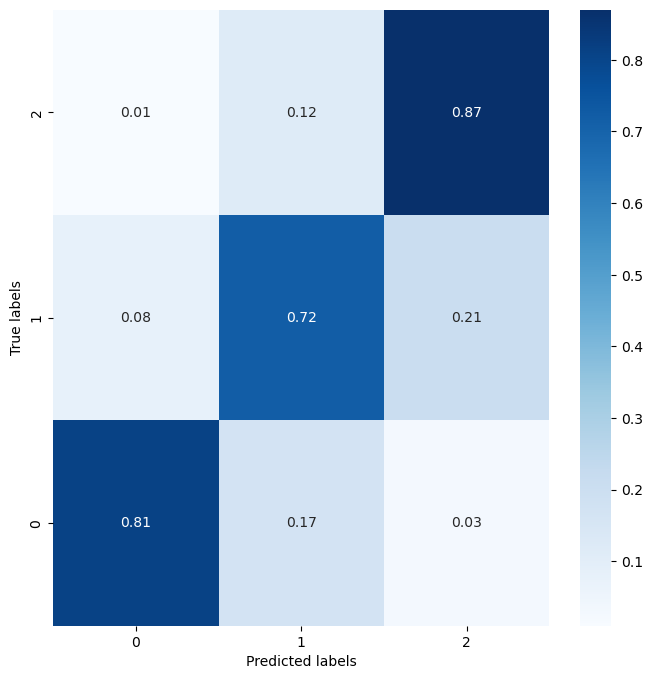

{'f1': 0.81327583088074,
 'acc': 0.8116733755031628,
 'precision': 0.8158598649544264,
 'recall': 0.8116733755031628,
 'kappa': 0.6950954783978878}

In [27]:
y_true = np.argmax(y_test, axis=1)
report_results(classifier_model, x_test, y_true)

D:\dev tools\anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


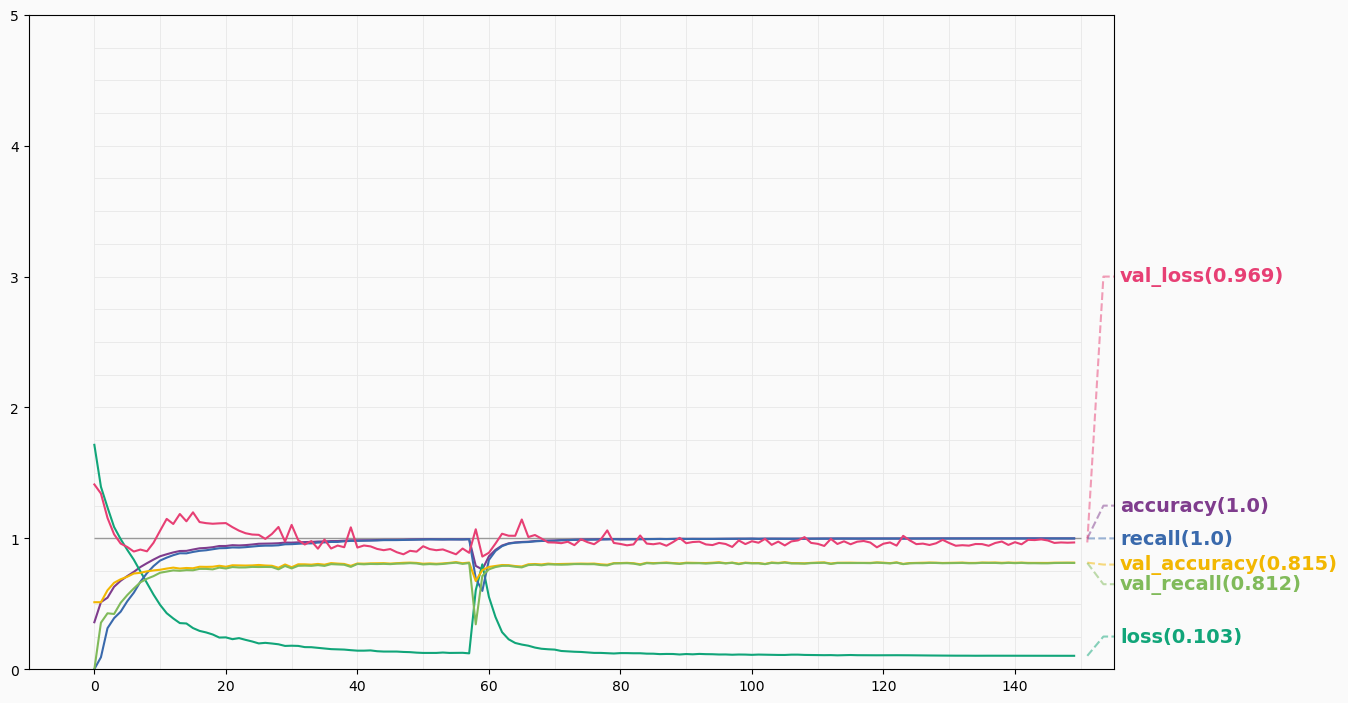

In [28]:
csv_path = 'C:/Users/ROG/OneDrive/桌面/FYP/Model/TWB_4_113_1.25/record.csv'
records = pd.read_csv(csv_path)

COLOR_SCALE = [
    "#7F3C8D", # accuracy
    "#11A579", # loss
    "#3969AC", # recall
    "#F2B701", # val_accuracy
    "#E73F74", # val_loss
    "#80BA5A"  # val_recall
]
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

fig, ax = plt.subplots(figsize = (14, 8.5))

fig.patch.set_facecolor("#fafafa")
ax.set_facecolor("#fafafa")
for h in np.arange(-10, 151, 10):
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)
ax.hlines(y=np.arange(0, 5, 0.25), xmin=0, xmax=150, color=GREY91, lw=0.6)
ax.hlines(y=1, xmin=0, xmax=150, color=GREY60, lw=1)

labels=['accuracy','loss','recall','val_accuracy','val_loss','val_recall']

for idx,label in enumerate(labels):
    data = records[label]
    color = COLOR_SCALE[idx]
    ax.plot(records['epoch'],data,color=color,lw=1.5)
    
ax.set_xlim(-10, 155)
ax.set_ylim(0, 5)

LABEL_Y = [
    1.25,  # accuracy
    0.25,  # loss
    1.0,    # recall
    0.8,   # val_accuracy
    3.0,  # val_loss
    0.65    # val_recall
]

x_start = 151
x_end = 156
PAD = 0.1
data_text = records.loc[records['epoch'] == 149]

for idx,label in enumerate(labels):
    data = data_text[label]
    color = COLOR_SCALE[idx]
    text = label + '(' + str(round(float(data),3)) + ')'
    y_start = data
    y_end = LABEL_Y[idx]
    ax.plot(
        [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD], 
        [y_start, y_end, y_end], 
        color=color, 
        alpha=0.5, 
        ls="dashed"
    )
    ax.text(
        x_end, 
        y_end, 
        text, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        #fontfamily="Montserrat", 
        va="center"
    )